In [1]:
import numpy as np
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing import image

# Rutas de los archivos
imagenes_train_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\train\imagenes_originales_train.npy"
imagenes_val_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\val\imagenes_originales_val.npy"
imagenes_test_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\test\imagenes_originales_test.npy"
heatmaps_train_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\train\heatmaps_train.npy"
heatmaps_val_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\val\heatmaps_val.npy"
heatmaps_test_path = r"D:\Tec\7mo Smestre\Inteligencia Artificial II\Reto\Datos\Arrays Heatmaps\test\heatmaps_test.npy"

# Cargar los archivos originales
imagenes_train = np.load(imagenes_train_path)
heatmaps_train = np.load(heatmaps_train_path)
imagenes_val = np.load(imagenes_val_path)
heatmaps_val = np.load(heatmaps_val_path)
imagenes_test = np.load(imagenes_test_path)
heatmaps_test = np.load(heatmaps_test_path)

# Convertir uint8 tensor a float32 y normalizar imágenes
imagenes_train = imagenes_train.astype('float32') / 255
imagenes_val = imagenes_val.astype('float32') / 255
imagenes_test = imagenes_test.astype('float32') / 255

# Normalizar mapas de calor originales
heatmaps_train = heatmaps_train / 255
heatmaps_val = heatmaps_val / 255
heatmaps_test = heatmaps_test / 255

# Función para reemplazar NaN con 0
def replace_nan_with_zero(array):
    return np.nan_to_num(array)

# Reemplazar NaN con 0 en las variables originales que tienen NaN
heatmaps_train = replace_nan_with_zero(heatmaps_train)
heatmaps_val = replace_nan_with_zero(heatmaps_val)
heatmaps_test = replace_nan_with_zero(heatmaps_test)

# Definir el aumento de datos
augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),  # Volteo horizontal con probabilidad del 50%
    iaa.Flipud(0.5),  # Volteo vertical con probabilidad del 50%
    iaa.Rotate((-45, 45)),  # Rotación en el rango de -45 a 45 grados
    iaa.GaussianBlur(sigma=(0, 3.0)),  # Desenfoque gaussiano con sigma en el rango de 0 a 3.0
    iaa.Affine(scale=(0.5, 1.5)),  # Escalamiento en el rango de 0.5 a 1.5
    iaa.AdditiveGaussianNoise(scale=(0, 0.1*255))  # Ruido gaussiano aditivo
])

# Aplicar data augmentation a los conjuntos de entrenamiento y validación
augmented_images_train, augmented_heatmaps_train = [], []
augmented_images_val, augmented_heatmaps_val = [], []

for i in range(len(imagenes_train)):
    augmented_image, augmented_heatmap = augmentation(images=imagenes_train[i:i+1], heatmaps=heatmaps_train[i:i+1])
    augmented_images_train.append(augmented_image[0])
    augmented_heatmaps_train.append(augmented_heatmap[0])

for i in range(len(imagenes_val)):
    augmented_image, augmented_heatmap = augmentation(images=imagenes_val[i:i+1], heatmaps=heatmaps_val[i:i+1])
    augmented_images_val.append(augmented_image[0])
    augmented_heatmaps_val.append(augmented_heatmap[0])

# Convertir a arrays numpy
augmented_images_train = np.array(augmented_images_train)
augmented_heatmaps_train = np.array(augmented_heatmaps_train)
augmented_images_val = np.array(augmented_images_val)
augmented_heatmaps_val = np.array(augmented_heatmaps_val)

# Concatenar imágenes y mapas de calor originales con los aumentados
imagenes_train = np.concatenate([imagenes_train, augmented_images_train], axis=0)
heatmaps_train = np.concatenate([heatmaps_train, augmented_heatmaps_train], axis=0)
imagenes_val = np.concatenate([imagenes_val, augmented_images_val], axis=0)
heatmaps_val = np.concatenate([heatmaps_val, augmented_heatmaps_val], axis=0)

# Asegurarse de que los valores estén en el rango [0, 1]
imagenes_train = np.clip(imagenes_train, 0, 1)
heatmaps_train = np.clip(heatmaps_train, 0, 1)
imagenes_val = np.clip(imagenes_val, 0, 1)
heatmaps_val = np.clip(heatmaps_val, 0, 1)

# Verificar nuevamente si hay valores NaN
nan_train_heatmaps_augmented = np.isnan(heatmaps_train).any()
nan_val_heatmaps_augmented = np.isnan(heatmaps_val).any()

# Imprimir los resultados después de la transformación
print("¿Hay valores NaN en mapas de calor de entrenamiento (aumentados)?", nan_train_heatmaps_augmented)
print("¿Hay valores NaN en mapas de calor de validación (aumentados)?", nan_val_heatmaps_augmented)

# Obtener el tamaño de cada array
size_imagenes_train_augmented = imagenes_train.shape
size_heatmaps_train_augmented = heatmaps_train.shape
size_imagenes_val_augmented = imagenes_val.shape
size_heatmaps_val_augmented = heatmaps_val.shape

# Imprimir los tamaños
print("Tamaño de imagenes_train_augmented:", size_imagenes_train_augmented)
print("Tamaño de heatmaps_train_augmented:", size_heatmaps_train_augmented)
print("Tamaño de imagenes_val_augmented:", size_imagenes_val_augmented)
print("Tamaño de heatmaps_val_augmented:", size_heatmaps_val_augmented)



¿Hay valores NaN en mapas de calor de entrenamiento (aumentados)? False
¿Hay valores NaN en mapas de calor de validación (aumentados)? False
Tamaño de imagenes_train_augmented: (29836, 112, 112, 3)
Tamaño de heatmaps_train_augmented: (29836, 112, 112, 7)
Tamaño de imagenes_val_augmented: (5152, 112, 112, 3)
Tamaño de heatmaps_val_augmented: (5152, 112, 112, 7)


In [4]:
import numpy as np

# Cargar los archivos originales
imagenes_train = np.load(imagenes_train_path)
heatmaps_train = np.load(heatmaps_train_path)
imagenes_val = np.load(imagenes_val_path)
heatmaps_val = np.load(heatmaps_val_path)
imagenes_test = np.load(imagenes_test_path)
heatmaps_test = np.load(heatmaps_test_path)

# Encontrar valores máximos y mínimos
max_imagenes_train, min_imagenes_train = np.max(imagenes_train), np.min(imagenes_train)
max_heatmaps_train, min_heatmaps_train = np.max(heatmaps_train), np.min(heatmaps_train)
max_imagenes_val, min_imagenes_val = np.max(imagenes_val), np.min(imagenes_val)
max_heatmaps_val, min_heatmaps_val = np.max(heatmaps_val), np.min(heatmaps_val)
max_imagenes_test, min_imagenes_test = np.max(imagenes_test), np.min(imagenes_test)
max_heatmaps_test, min_heatmaps_test = np.max(heatmaps_test), np.min(heatmaps_test)

# Imprimir los resultados
print("Imagenes Train - Max:", max_imagenes_train, "Min:", min_imagenes_train)
print("Heatmaps Train - Max:", max_heatmaps_train, "Min:", min_heatmaps_train)
print("Imagenes Val - Max:", max_imagenes_val, "Min:", min_imagenes_val)
print("Heatmaps Val - Max:", max_heatmaps_val, "Min:", min_heatmaps_val)
print("Imagenes Test - Max:", max_imagenes_test, "Min:", min_imagenes_test)
print("Heatmaps Test - Max:", max_heatmaps_test, "Min:", min_heatmaps_test)



Imagenes Train - Max: 255 Min: 0
Heatmaps Train - Max: nan Min: nan
Imagenes Val - Max: 255 Min: 0
Heatmaps Val - Max: nan Min: nan
Imagenes Test - Max: 255 Min: 0
Heatmaps Test - Max: nan Min: nan


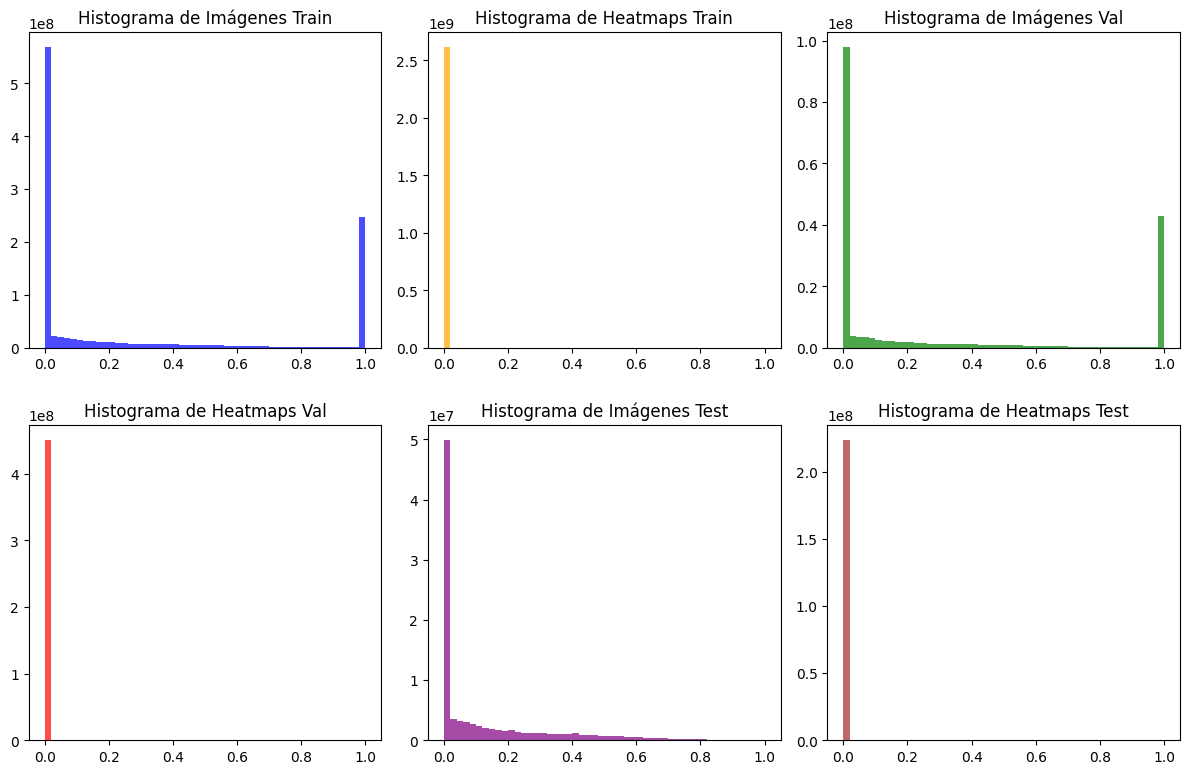

In [2]:
import matplotlib.pyplot as plt

# Crear histogramas
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.hist(imagenes_train.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histograma de Imágenes Train')

plt.subplot(2, 3, 2)
plt.hist(heatmaps_train.flatten(), bins=50, color='orange', alpha=0.7)
plt.title('Histograma de Heatmaps Train')

plt.subplot(2, 3, 3)
plt.hist(imagenes_val.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Histograma de Imágenes Val')

plt.subplot(2, 3, 4)
plt.hist(heatmaps_val.flatten(), bins=50, color='red', alpha=0.7)
plt.title('Histograma de Heatmaps Val')

plt.subplot(2, 3, 5)
plt.hist(imagenes_test.flatten(), bins=50, color='purple', alpha=0.7)
plt.title('Histograma de Imágenes Test')

plt.subplot(2, 3, 6)
plt.hist(heatmaps_test.flatten(), bins=50, color='brown', alpha=0.7)
plt.title('Histograma de Heatmaps Test')

plt.tight_layout()
plt.show()

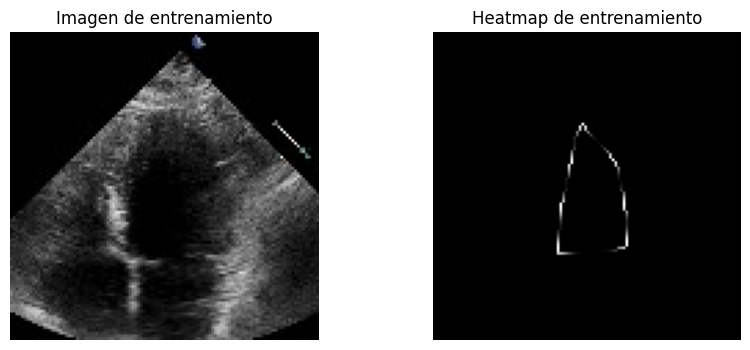

In [4]:
# Seleccionamos la primera imagen de los conjuntos de entrenamiento
imagen = imagenes_test[11]
heatmap = heatmaps_test[11]

# Visualizamos la imagen de entrenamiento
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(imagen)
plt.title('Imagen de entrenamiento')
plt.axis('off')

# Para el heatmap, sumamos los canales para obtener una imagen en escala de grises
heatmap_gris = np.sum(heatmap, axis=-1)

# Normalizamos la imagen para que sus valores estén entre 0 y 1
heatmap_gris = (heatmap_gris - np.min(heatmap_gris)) / (np.max(heatmap_gris) - np.min(heatmap_gris))

plt.subplot(1, 2, 2)
plt.imshow(heatmap_gris, cmap='gray')
plt.title('Heatmap de entrenamiento')
plt.axis('off')

plt.show()

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Reshape
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, MAE
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
# Define la clase del generador de datos
class DataGenerator(Sequence):
    def __init__(self, imagenes, heatmaps, batch_size=16):
        self.imagenes = imagenes
        self.heatmaps = heatmaps
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.imagenes))

    def __len__(self):
        return int(np.ceil(len(self.imagenes) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_x = self.imagenes[start:end]
        batch_y = self.heatmaps[start:end]
        return batch_x, batch_y

In [24]:
import tensorflow as tf
from tensorflow.keras.losses import Loss

class CustomLoss(Loss):
    def __init__(self, name='custom_loss'):
        super(CustomLoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        # y_true y y_pred son tensores de forma (batch_size, 112, 112, 7)
        
        # Calcula la pérdida canal por canal
        channel_losses = []
        for i in range(7):
            # Extrae el canal i de y_true e y_pred
            true_channel = y_true[:, :, :, i]
            pred_channel = y_pred[:, :, :, i]

            # Calcula la pérdida para el canal i (puedes personalizar la pérdida aquí)
            channel_loss = tf.keras.losses.MeanSquaredError()(true_channel, pred_channel)
            
            # Agrega la pérdida del canal i a la lista
            channel_losses.append(channel_loss)
        
        # Devuelve la pérdida total como la media de las pérdidas de cada canal
        return tf.reduce_mean(channel_losses, axis=0)


In [26]:
# Crear un modelo secuencial
model = Sequential()

# Base convolucional
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001), input_shape=(112, 112, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.5))


# Regularización L2
model.add(Flatten())
model.add(Dense(112, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dense(112 * 112 * 7, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Reshape((112, 112, 7, 1)))
                              

opt = Adam(learning_rate=0.0001)  # Puedes ajustar el valor de learning rate según sea necesario
model.compile(optimizer=opt, loss=CustomLoss(), metrics=['Accuracy'])

# Crear instancias del generador de datos para entrenamiento y validación
train_generator = DataGenerator(imagenes_train, heatmaps_train, batch_size=16)
val_generator = DataGenerator(imagenes_val, heatmaps_val, batch_size=16)
test_generator = DataGenerator(imagenes_test, heatmaps_test, batch_size=16)

# Entrenar el modelo
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

# Evaluar el modelo en datos de prueba utilizando el generador
test_loss, test_dice_score = model.evaluate(test_generator)
print(f'Loss en datos de prueba: {test_loss}')
print(f'DICE SCORE en datos de prueba: {test_dice_score}')

Epoch 1/5
1865/1865 [==============================] - 63s 32ms/step - loss: 0.5530 - Accuracy: 0.2978 - val_loss: 0.4213 - val_Accuracy: 0.5138
Epoch 2/5
1865/1865 [==============================] - 61s 33ms/step - loss: 0.5069 - Accuracy: 0.2978 - val_loss: 0.3799 - val_Accuracy: 0.5342
Epoch 3/5
1865/1865 [==============================] - 59s 32ms/step - loss: 0.4692 - Accuracy: 0.2978 - val_loss: 0.3461 - val_Accuracy: 0.5560
Epoch 4/5
1865/1865 [==============================] - 59s 32ms/step - loss: 0.4385 - Accuracy: 0.2978 - val_loss: 0.3187 - val_Accuracy: 0.5775
Epoch 5/5
160/160 [==============================] - 3s 16ms/step - loss: 0.2971 - Accuracy: 0.6117
Loss en datos de prueba: 0.29713118076324463
DICE SCORE en datos de prueba: 0.6116962432861328


1/1 [==============================] - 0s 13ms/step


(1, 112, 112, 7, 1)


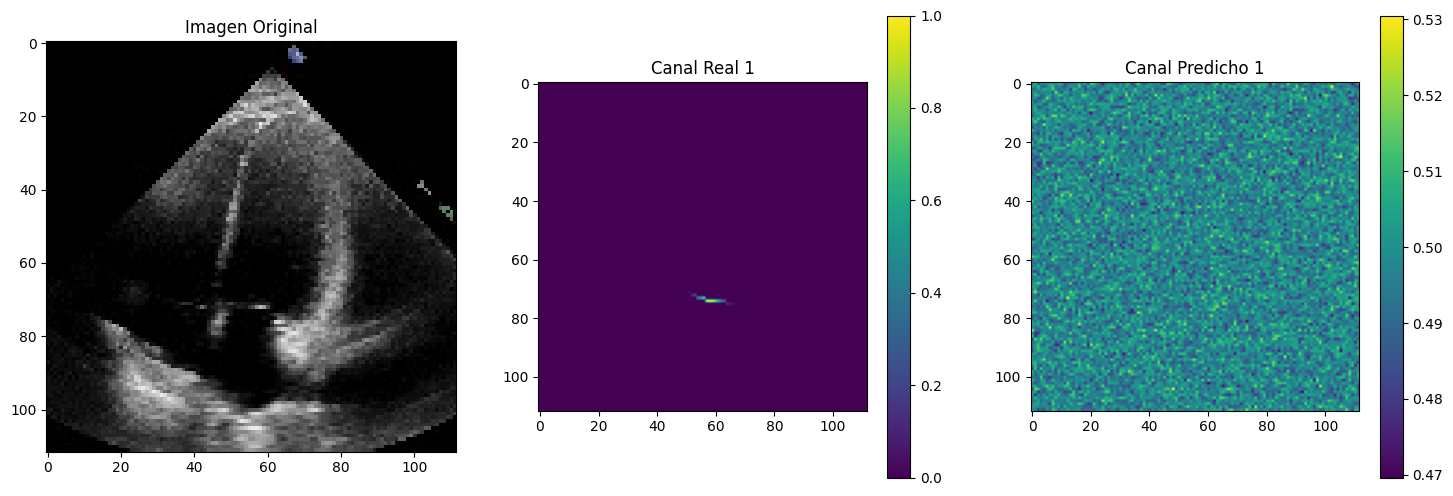

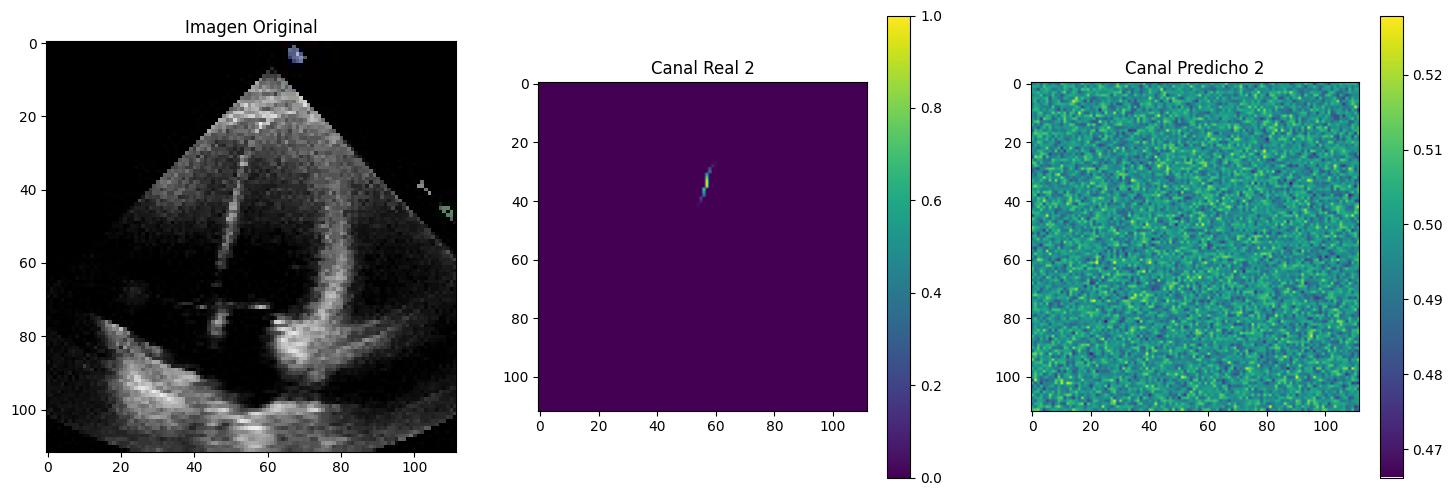

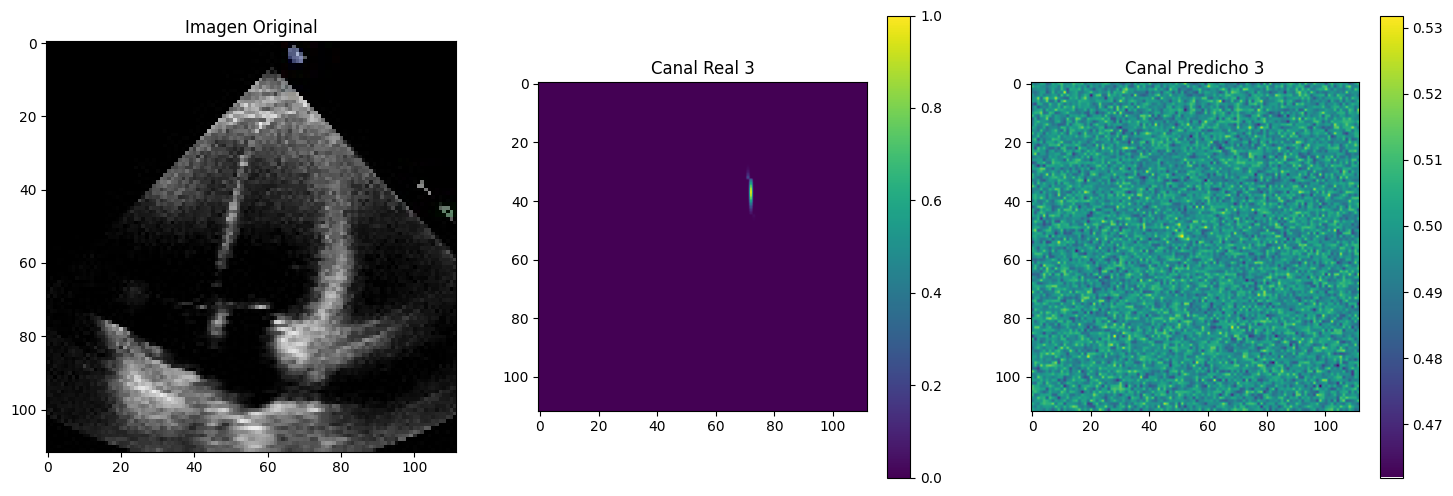

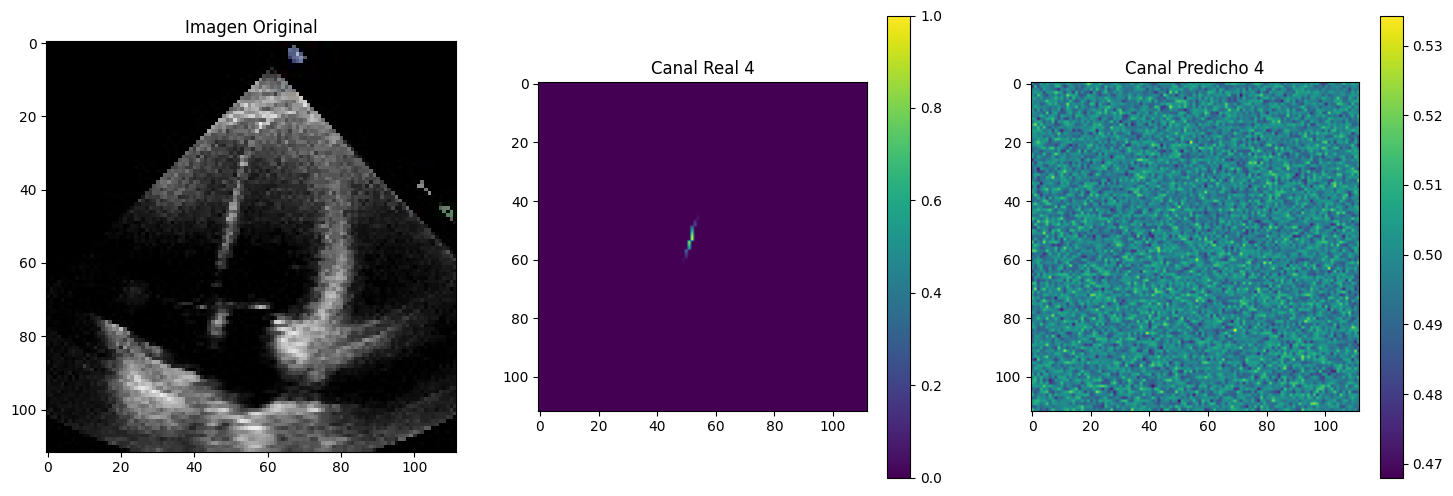

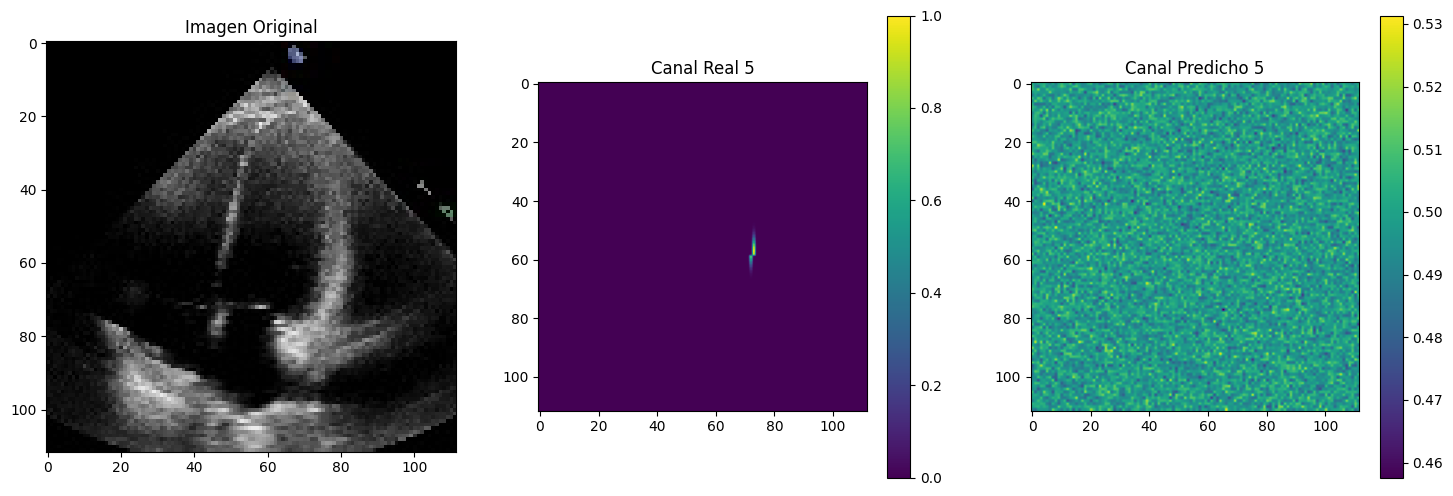

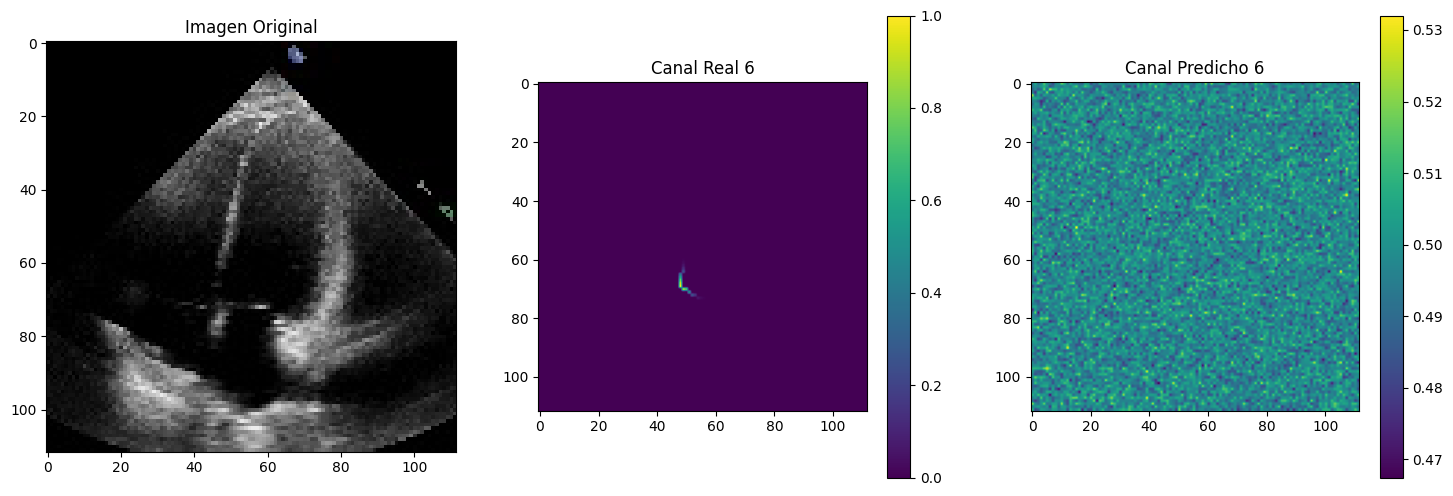

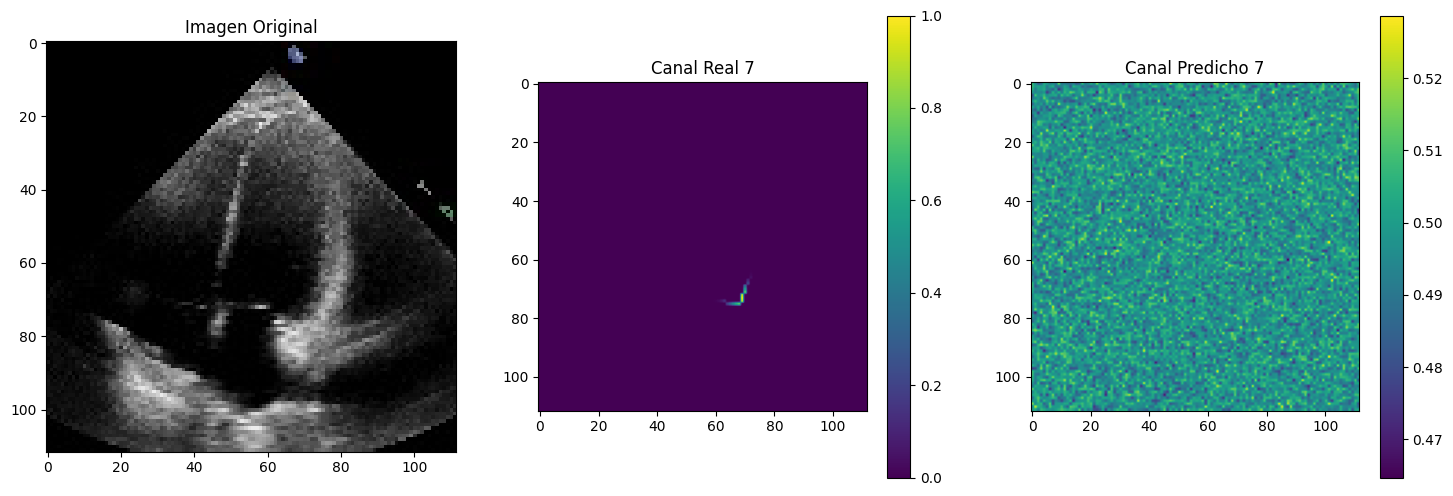

In [28]:
from keras.preprocessing import image
import numpy as np

# Selecciona una imagen de imagenes_test
indice_imagen_test = 200  # Cambia esto al índice de la imagen que deseas usar
img_array = imagenes_test[indice_imagen_test]

# Añade una dimensión extra para el lote
img_array = np.expand_dims(img_array, axis=0)

# Realiza la predicción
heatmap_pred = model.predict(img_array)

# Puedes imprimir o manipular el resultado según tus necesidades
print(heatmap_pred.shape)  # Esto imprimirá las dimensiones del mapa de calor predicho

# Obtén el mapa de contornos real directamente de heatmaps_test
true_heatmap = heatmaps_test[indice_imagen_test]

# Itera sobre los canales y muestra cada imagen, canal real y canal predicho en una fila
for canal in range(heatmap_pred.shape[-2]):
    plt.figure(figsize=(18, 6))

    # Muestra la imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(img_array[0])
    plt.title('Imagen Original')

    # Muestra el canal real
    plt.subplot(1, 3, 2)
    plt.imshow(true_heatmap[:, :, canal], cmap='viridis')
    plt.title(f'Canal Real {canal + 1}')
    plt.colorbar()

    # Muestra el canal predicho
    plt.subplot(1, 3, 3)
    plt.imshow(heatmap_pred[0, :, :, canal, 0], cmap='viridis')  # Puedes cambiar el mapa de colores según tus preferencias
    plt.title(f'Canal Predicho {canal + 1}')
    plt.colorbar()

    plt.show()


